In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

In [5]:
# Tickers
tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X']

# dates
startdate = '2015-1-1'
train_end = '2017-12-31'
test_start = '2018-01-01'
enddate = '2018-12-31'

# data Close
data_close = pdr.get_data_yahoo(tickers, start=startdate, end=enddate)['Adj Close']
print('\n--- Full dataset')
# display(data_close)

# data returns
data = data_close.shift(1) / data_close - 1
print('\n--- Full dataset returns')
# display(data)

# Sets
data_train = data[startdate:train_end].dropna()
data_test = data[test_start:enddate].dropna()
print('\n--- Train set unadjusted')
# display(data_train)
print('\n--- Test set unadjusted')
# display(data_test)

# mu sigma train
mu_train = data_train.mean()
sigma_train = data_train.std()
print('\n--- mu train:')
# display(pd.DataFrame(mu_train, columns=['Train set Mean']))
print('\n--- sigma train:')
# display(pd.DataFrame(sigma_train, columns=['Train set st dev']))

# Final sets
data_train_prod = (data_train - mu_train) / sigma_train
data_test_prod = (data_test - mu_train) / sigma_train
print('\n--- Train set adjusted')
# display(data_train_prod)
print('\n--- Test set adjusted')
# display(data_test_prod)

[*********************100%***********************]  8 of 8 completed

--- Full dataset

--- Full dataset returns

--- Train set unadjusted

--- Test set unadjusted

--- mu train:

--- sigma train:

--- Train set adjusted

--- Test set adjusted


In [6]:
data_train_prod.columns

Index(['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X', '^GSPC',
       '^TNX', '^VIX'],
      dtype='object')

In [53]:
win_length = 2 ** (4-1) * 2
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_gen_df = data_train_prod['EURUSD=X']
test_gen_df = data_test_prod['EURUSD=X']
train_data_gen = TimeseriesGenerator(train_gen_df.values, train_gen_df, length=win_length)
test_data_gen = TimeseriesGenerator(test_gen_df.values, test_gen_df, length=win_length)
train_data_gen[0][0].shape

(128, 16)

In [54]:
# Try longer/shorter batch size

## Wavenet

In [55]:
# https://github.com/usernaamee/keras-wavenet/blob/master/simple-generative-model.py

In [56]:
from tensorflow.keras.layers import Convolution1D, Convolution2D, Flatten, Dense, \
    Input, Lambda, Activation, BatchNormalization
from tensorflow import keras
import tensorflow

def WaveNetBlock(filters, kernel_size, dilation_rate, activation=None):
    def f(input_):
        residual = input_
        tanh_out = Convolution1D(filters, kernel_size,
                                       dilation_rate=dilation_rate,
                                       padding='same',
                                       activation='tanh')(input_)
        sigmoid_out = Convolution1D(filters, kernel_size,
                                          dilation_rate=dilation_rate,
                                          padding='same',
                                          activation='relu')(input_)
        merged = keras.layers.Multiply()([tanh_out, sigmoid_out])
        skip_out = Convolution1D(1, 1, activation=activation, padding='same')(merged)
        out = keras.layers.Add()([skip_out, residual])
        return out, skip_out
#         return skip_out
    return f

In [57]:
def evaluate_model(model, hist):
    total_mae = mean_absolute_error(train_gen_df[win_length:], np.zeros_like(train_gen_df[win_length:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(train_data_gen)), train_gen_df[win_length:]) 
    print('train', model_mae, total_mae, model_mae/total_mae)
    total_mae = mean_absolute_error(test_gen_df[win_length:], np.zeros_like(test_gen_df[win_length:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(test_data_gen)), test_gen_df[win_length:]) 
    print('test', model_mae, total_mae, model_mae/total_mae)
    plt.scatter(np.squeeze(model.predict(train_data_gen)), train_gen_df[win_length:])
    plt.title('training')
    plt.xlabel('prediction')
    plt.subplots()
    plt.scatter(np.squeeze(model.predict(test_data_gen)), test_gen_df[win_length:])
    plt.title('testing')
    plt.xlabel('prediction')
    pd.DataFrame(hist.history).plot()

Simple Dilated Covnet, filter=1, kernel=1

In [58]:
# try deactivate gpu here

In [61]:
def conv_one():
    x = i = Input(shape=(win_length, 1))
    x = BatchNormalization()(x)
    x = Convolution1D(filters=1, kernel_size=2, dilation_rate=2**1, padding='same', activation='relu')(x)
    x = Convolution1D(filters=1, kernel_size=2, dilation_rate=2**2, padding='same', activation='relu')(x)
    x = Convolution1D(filters=1, kernel_size=2, dilation_rate=2**3, padding='same', activation='relu')(x)
    x = Convolution1D(filters=1, kernel_size=2, dilation_rate=2**4, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(1, activation='linear', kernel_regularizer='l2')(x)
    model = keras.Model(i, x)
    return model

In [74]:
def wave_one():
    x = i = Input(shape=(win_length, 1))
    x = BatchNormalization()(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**1, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**2, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**3, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**4, activation='relu')(x)

    x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(1, activation='linear', kernel_regularizer='l2')(x)
    model = keras.Model(i, x)
    return model

In [15]:
def conv_multi_extra_layer():
    x = i = Input(shape=(30, 1))
    x = BatchNormalization()(x)
    x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
    x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
    x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
    x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
    x = Dense(1, activation='linear', kernel_regularizer='l2')(x)
    model = keras.Model(i, x)
    return model

In [16]:
def conv_multi_extra_layer_unregularized():
    x = i = Input(shape=(30, 1))
    x = BatchNormalization()(x)
    x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
    x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
    x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
    x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(30, activation='relu')(x)
    x = Dense(1, activation='linear')(x)
    model = keras.Model(i, x)
    return model

In [17]:
def wave_multi_extra_layer():
    x = i = Input(shape=(30, 1))
    x = BatchNormalization()(x)
    x, _ = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
    x, _ = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
    x, _ = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
    x, _ = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
    x = Dense(1, activation='linear', kernel_regularizer='l2')(x)
    model = keras.Model(i, x)
    return model

In [18]:
def wave_multi_extra_layer_unregularised():
    x = i = Input(shape=(30, 1))
    x = BatchNormalization()(x)
    x, _ = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
    x, _ = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
    x, _ = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
    x, _ = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(30, activation='relu')(x)
    x = Dense(1, activation='linear')(x)
    model = keras.Model(i, x)
    return model

train 0.726453512838681 0.7268768687218004 0.9994175686401139
test 0.5829562392796505 0.5831644711137639 0.9996429277769344


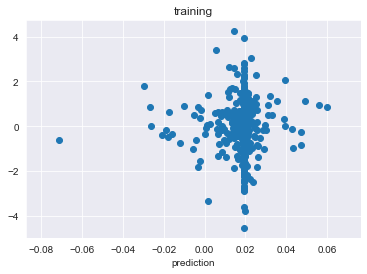

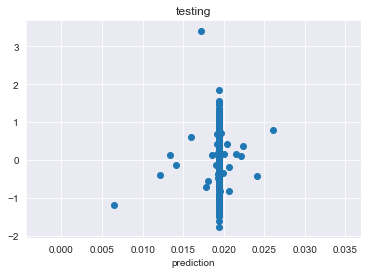

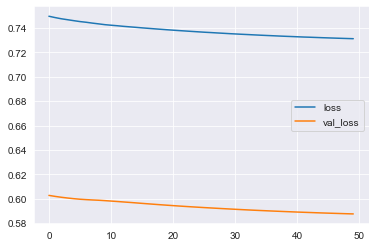

In [62]:
model = conv_one()
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

Wavenet, filter=1, kernel=1

train 0.7462735412135013 0.7268768687218004 1.0266849494410375
test 0.5852722281477898 0.5831644711137639 1.0036143440460294


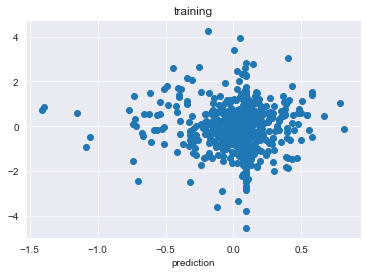

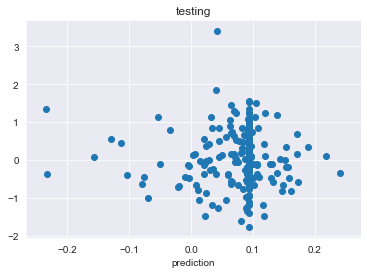

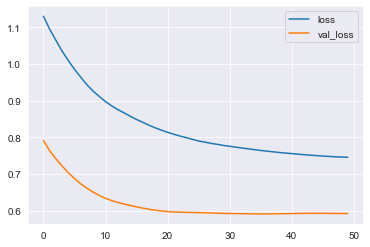

In [75]:
model = wave_one()
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

ConvNet, variable filters / kernel_size

train 0.5068540204868875 0.7216526846405319 0.7023517424304472
test 0.6525960002010205 0.5774699337135029 1.13009519994298


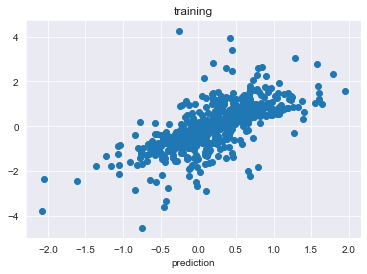

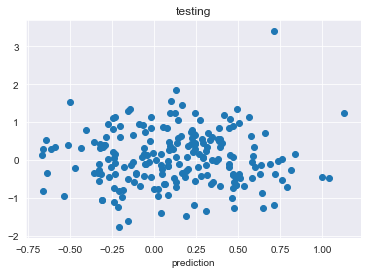

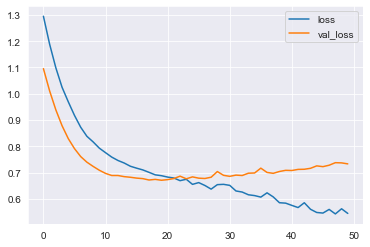

In [22]:
model = conv_multi_extra_layer()
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

ConvNet, variable filters / kernel_size, final layer non-regularised

train 0.3174306792047083 0.7216526846405319 0.43986627634154263
test 0.6477112791239362 0.5774699337135029 1.1216363680767523


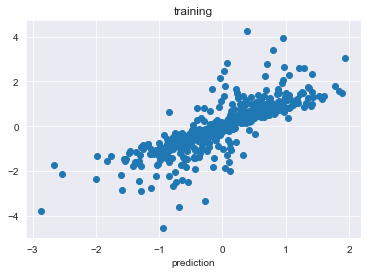

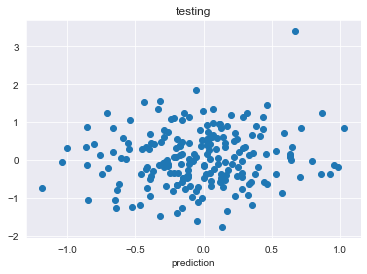

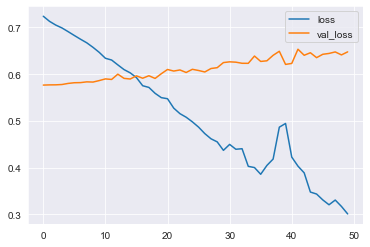

In [23]:
model = conv_multi_extra_layer_unregularized()
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

WaveNet, variable filter/kernel

train 0.6242070013868259 0.7216526846405319 0.8649687234209551
test 0.5936846622397592 0.5774699337135029 1.0280789138613422


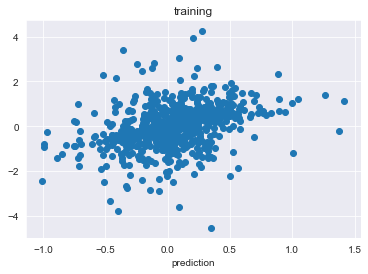

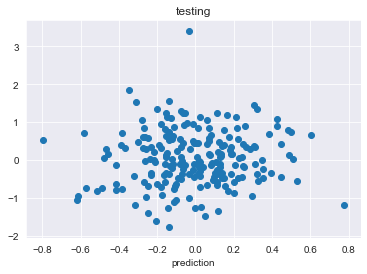

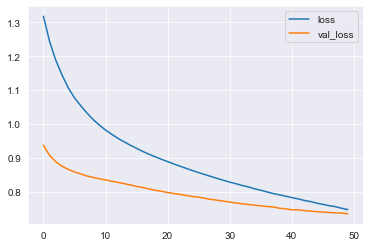

In [24]:
model = wave_multi_extra_layer()
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

WaveNet, variable filter/kernel, non-regularised

train 0.6310933365796765 0.7216526846405319 0.8745111741585709
test 0.6174363157990911 0.5774699337135029 1.0692094596658543


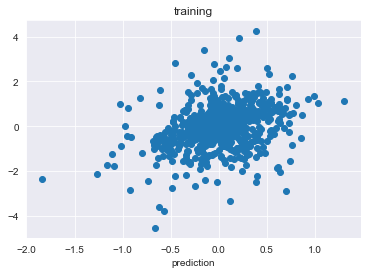

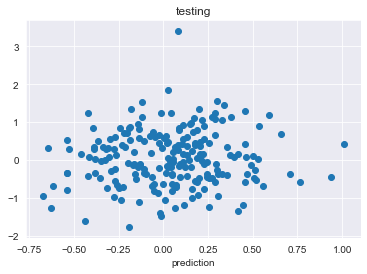

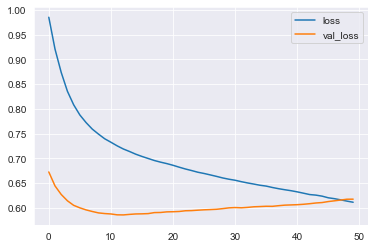

In [25]:
model = wave_multi_extra_layer_unregularised()
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

In [ ]:
tf.config.experimental.list_logical_devices()